In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/Shared drives/DKD/Deeplearning/Covid-19"
! ls 

/content/gdrive/Shared drives/DKD/Deeplearning/Covid-19
Covid-Resnet.ipynb  Dataset	 model_Resnet50_Covid.h5
Covid_test1.h5	    Dataset.rar  model_Resnet50_Covid.json


In [ ]:
# !unrar x "/content/gdrive/Shared drives/DKD/Deeplearning/Covid-19/Dataset.rar" "/content/gdrive/Shared drives/DKD/Deeplearning/Covid-19"

In [ ]:
!ls

Covid-Resnet.ipynb  Covid_test1.h5  Dataset  Dataset.rar


# **DATA PREPROCESSING**

In [3]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

In [4]:
traindf=pd.read_csv("Dataset/train.csv",dtype=str)
validdf = pd.read_csv("Dataset/valid.csv", dtype = str)

testdf = pd.read_csv("Dataset/test.csv", dtype = str)
#testdf=pd.read_csv("./sampleSubmission.csv",dtype=str)


In [5]:
Batch_size = 8
img_h = 256
img_w = 256
num_classes=4

In [6]:
from sklearn.utils import class_weight

train_data_gen = ImageDataGenerator(
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=[0.3, 1],
                                    horizontal_flip=True,
                                    shear_range = 0.2,
                                    vertical_flip=True,
                                    fill_mode='nearest',
                                    #cval=0,
                                    rescale=1./255)

train_generator=train_data_gen.flow_from_dataframe(
          dataframe=traindf,
          directory="Dataset/Train",
          x_col="Image",
          y_col="Covid_19",
          #subset="training",
          batch_size=Batch_size,
          seed=42,
          shuffle=True,
          class_mode="binary",
          target_size=(img_h, img_w)
          )


valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator=valid_data_gen.flow_from_dataframe(
        dataframe=validdf,
        directory="Dataset/Train",
        x_col="Image",
        y_col="Covid_19",
        #subset="validation",
        batch_size=Batch_size,
        seed=42,
        shuffle=True,
        class_mode="binary",
        target_size=(img_h, img_w)
        )

test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator=test_data_gen.flow_from_dataframe(
        dataframe=testdf,
        directory="Dataset/Test",
        x_col="Image",
        y_col="Covid_19",
        #subset="validation",
        batch_size=Batch_size,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=(img_h, img_w)
        )


class_weights_list = class_weight.compute_class_weight('balanced',
                                                   np.unique(train_generator.classes),
                                                   train_generator.classes )
print('class_weight: {}'.format(class_weights_list) )

Found 260 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 80 validated image filenames.
class_weight: [0.92857143 1.08333333]


In [7]:
class_weights = {}
for i in range(2):
  class_weights[i] =  class_weights_list[i]

print(train_generator.class_indices)
print(valid_generator.class_indices)
print(class_weights)

{'0': 0, '1': 1}
{'0': 0, '1': 1}
{0: 0.9285714285714286, 1: 1.0833333333333333}


# **Model Resnet-50v2**

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
ResNet_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=1, activation='sigmoid')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
transfer_learning_history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=30,
                  callbacks=callbacks,
                  class_weight=class_weights
                                
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
32/32 [==============================] - 139s 4s/step - loss: 0.4174 - accuracy: 0.8254 - val_loss: 0.2834 - val_accuracy: 0.9750
Epoch 2/30
32/32 [==============================] - 10s 306ms/step - loss: 0.1857 - accuracy: 0.9524 - val_loss: 0.0742 - val_accuracy: 0.9750
Epoch 3/30
32/32 [==============================] - 10s 306ms/step - loss: 0.3988 - accuracy: 0.9206 - val_loss: 0.0513 - val_accuracy: 0.9750
Epoch 4/30
32/32 [==============================] - 10s 311ms/step - loss: 0.1269 - accuracy: 0.9603 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 10s 307ms/step - loss: 0.2398 - accuracy: 0.9444 - val_loss: 4.1907e-06 - val_accuracy: 1.0000
Epoch 6/30
32/32 [==============================] - 10s 306ms/step - loss: 0.1300 - accuracy: 0.9603 - val_loss: 5.0054e-11 - val_accuracy: 1.0000
Epoch 7/30
32/32 [==============================] - ETA: 0s 

***SAVE THE MODEL***

In [ ]:
#SAVE THE MODEL
#model.save('Covid_test1.h5')

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_Resnet50_Covid.json", "w") as json_file:
    json_file.write(model_json)


# serialize weights to HDF5
model.save_weights("model_Resnet50_Covid.h5")
print("Saved model to disk")

Saved model to disk


# **Visualization accuracy and loss**

Text(0.5, 1.0, 'Training and Validation Loss')

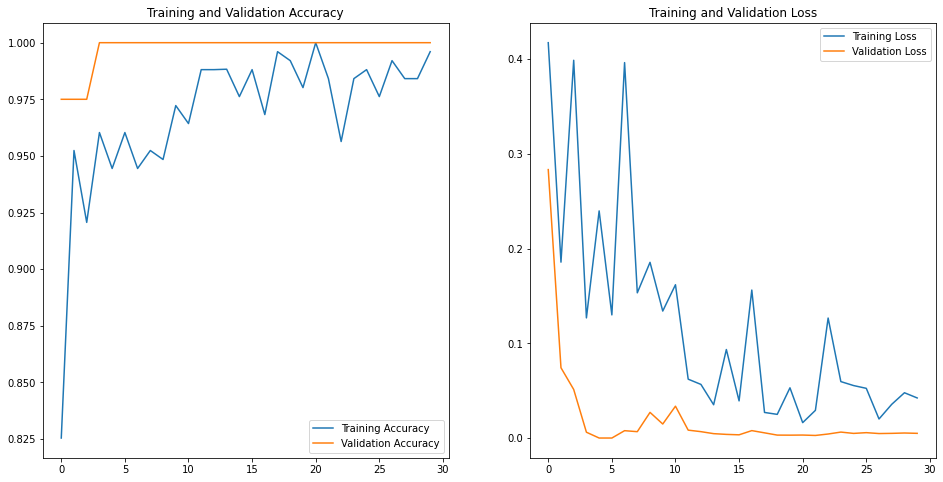

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# **Load Model by .H5 file and Test**

In [8]:
# model.load_weights('Covid_test1.h5')
from keras.models import load_model
# load model
model = load_model('Covid_test1.h5')

In [10]:
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n//test_generator.batch_size)
#print(pred)
y_pred = []
for i in pred:
  if i[0] >= 0.4: #>=80% positive
    y_pred.append(1)
  else:
    y_pred.append(0)

count_negative_pred = 0
count_positive_pred = 0
for i in  y_pred:
  if i==0:
    count_negative_pred+=1
  else:
    count_positive_pred+=1

print("The number of positive prediction:",count_positive_pred)
print("The number of negative prediction:",count_negative_pred)

print("============REALITY=====================")

count_negative_real = 0
count_positive_real = 0
for i in testdf['Covid_19']:
  if int(i)==0:
    count_negative_real+=1
  else:
    count_positive_real+=1

print("The number of positive reality:",count_positive_real)
print("The number of negative reality:",count_negative_real)


10/10 [==============================] - 2s 206ms/step
The number of positive prediction: 40
The number of negative prediction: 40
============REALITY=====================
The number of positive reality: 40
The number of negative reality: 40


# **LOAD MODEL WITH JSON AND WEIGHT BY .H5**

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('model_Resnet50_Covid.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_Resnet50_Covid.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
pred=loaded_model.predict_generator(test_generator,verbose=1,steps=test_generator.n//test_generator.batch_size)
#print(pred)
y_pred = []
for i in pred:
  if i[0] >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

count_negative_pred = 0
count_positive_pred = 0
for i in  y_pred:
  if i==0:
    count_negative_pred+=1
  else:
    count_positive_pred+=1

print("The number of positive prediction:",count_positive_pred)
print("The number of negative prediction:",count_negative_pred)

print("============REALITY=====================")

count_negative_real = 0
count_positive_real = 0
for i in testdf['Covid_19']:
  if int(i)==0:
    count_negative_real+=1
  else:
    count_positive_real+=1

print("The number of positive reality:",count_positive_real)
print("The number of negative reality:",count_negative_real)

10/10 [==============================] - 2s 195ms/step
The number of positive prediction: 40
The number of negative prediction: 40
============REALITY=====================
The number of positive reality: 40
The number of negative reality: 40
